This analysis is following the recent disaster happened in Acheh, Indonesia on 26th December 2004
<br>Data is collected from https://earthquake.usgs.gov
<br>Filter applied to limit data based on coordinate,

In [1]:
# Import required libraries
import datetime
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize

# Data Collection

In [2]:
# set the date as 6th December 2004
# the program will loop for the number of iteration for a period of 30 days
baseDate = '26 December 2004'
rangeDate = 7    # we're collecting data 1 week before/after the baseDate

# set the boundaries of location (covering South East Asia)
latMin = -15
latMax = 15
lonMin = 90
lonMax = 140

In [3]:
# Custom function to record coordinate into separate lon/lat columns
# input : the coordinate as [longitude, latitude, depth]
# output : Series of lon/lat
def splitCoordinate(coor):
    lon,lat,elav = coor
    
    return pd.Series([lon,lat])

In [4]:
dt = datetime.datetime.strptime(baseDate, '%d %B %Y')

startDate = dt - datetime.timedelta(days=rangeDate)
endDate = dt + datetime.timedelta(days=rangeDate)

# construct the url used to download the data
urlStart = startDate.strftime("%Y-%m-%d")
urlEnd = endDate.strftime("%Y-%m-%d")
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime='+urlStart+'&endtime='+urlEnd

# submit the request
resp = requests.get(url=url)
data = resp.json()

# process the JSON response
block_df = json_normalize(data['features'])

# create new column for lon/lat
# so that we can scope the output only for the required region
block_df[['lon','lat']] = block_df['geometry.coordinates'].apply(splitCoordinate)

# define the boundaries based on lon/lat
location_latitude = (block_df['lat'] > latMin) & (block_df['lat'] < latMax)
location_longitude = (block_df['lon'] > lonMin) & (block_df['lon'] < lonMax)

# filter the response only to have earthquake on selected region
regional_df = block_df[ location_latitude & location_longitude ]

# combine the filtered response into master dataframe
master_df = pd.DataFrame()
master_df = master_df.append(regional_df, ignore_index = True)

master_df.head()

,geometry.coordinates,geometry.type,id,properties.alert,properties.cdi,properties.code,properties.detail,properties.dmin,properties.felt,properties.gap,...,properties.title,properties.tsunami,properties.type,properties.types,properties.tz,properties.updated,properties.url,type,lon,lat
0,"[96.486, 3.177, 30]",Point,usp000dcd2,None,NaN,p000dcd2,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,90.1,...,"M 4.9 - northern Sumatra, Indonesia",0,earthquake,",focal-mechanism,impact-text,moment-tensor,ori...",NaN,1478739450984,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,96.486,3.177
1,"[92.937, 5.707, 30]",Point,usp000dcd0,None,NaN,p000dcd0,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,177.9,...,M 4.8 - off the west coast of northern Sumatra,0,earthquake,",impact-text,origin,phase-data,",NaN,1415323471887,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,92.937,5.707
2,"[93.344, 8.144, 30]",Point,usp000dccy,None,NaN,p000dccy,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,101.1,...,"M 4.9 - Nicobar Islands, India region",0,earthquake,",impact-text,origin,phase-data,",NaN,1415323471875,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,93.344,8.144
3,"[92.626, 9.026, 30]",Point,usp000dccv,None,NaN,p000dccv,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,68.0,...,"M 5.2 - Nicobar Islands, India region",0,earthquake,",focal-mechanism,impact-text,moment-tensor,ori...",NaN,1478739450475,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,92.626,9.026
4,"[92.765, 7.192, 10]",Point,usp000dccu,None,NaN,p000dccu,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,58.2,...,"M 5.5 - Nicobar Islands, India region",0,earthquake,",focal-mechanism,impact-text,moment-tensor,mom...",NaN,1478739449981,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,92.765,7.192


# Process the Collected Data

In [5]:
# Check on the shape of the dataframe, which give total data we collected
master_df.shape

(793, 32)

<b>793 earthquakes</b> rocks the area within 1 week before and after 26th December 2004

In [6]:
# Check on the available columns
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 32 columns):
geometry.coordinates    793 non-null object
geometry.type           793 non-null object
id                      793 non-null object
properties.alert        0 non-null object
properties.cdi          5 non-null float64
properties.code         793 non-null object
properties.detail       793 non-null object
properties.dmin         0 non-null float64
properties.felt         5 non-null float64
properties.gap          792 non-null float64
properties.ids          793 non-null object
properties.mag          793 non-null float64
properties.magType      781 non-null object
properties.mmi          15 non-null float64
properties.net          793 non-null object
properties.nst          792 non-null float64
properties.place        793 non-null object
properties.rms          792 non-null float64
properties.sig          793 non-null int64
properties.sources      793 non-null object
properties.status

For earthquake we probably interested to know:

1. When it happened (date/time) --> properties.time
2. What was the magnitude --> properties.mag
3. Where it happened --> properties.place
4. Coordinate so that it can be plotted --> geometry.coordinates

Details of the availble data can be found from https://earthquake.usgs.gov/data/comcat/data-eventterms.php

In [7]:
# make a copy of the original dataframe
#earthquake_df = master_df[['geometry.coordinates','properties.mag','properties.place','properties.time','lon','lat']].copy()
earthquake_df = master_df.copy()

In [8]:
# Times are reported in milliseconds since the epoch, and provided in UTC
# good to convert this into human readable format

def convertEpochToReadable(dt):
    time1 = float(dt/1000)
    dt_date = datetime.datetime.fromtimestamp(time1).strftime('%d-%m-%Y')
    dt_time = datetime.datetime.fromtimestamp(time1).strftime('%H:%M:%S')
    
    return pd.Series([dt_date, dt_time])

print 'Converted\t:',convertEpochToReadable(master_df['properties.time'][0])

Converted	: 0    02-01-2005
1      07:40:29
dtype: object


In [9]:
# apply the function
earthquake_df[['date','time']] = earthquake_df['properties.time'].apply(convertEpochToReadable)
earthquake_df.head()

,geometry.coordinates,geometry.type,id,properties.alert,properties.cdi,properties.code,properties.detail,properties.dmin,properties.felt,properties.gap,...,properties.type,properties.types,properties.tz,properties.updated,properties.url,type,lon,lat,date,time
0,"[96.486, 3.177, 30]",Point,usp000dcd2,None,NaN,p000dcd2,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,90.1,...,earthquake,",focal-mechanism,impact-text,moment-tensor,ori...",NaN,1478739450984,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,96.486,3.177,02-01-2005,07:40:29
1,"[92.937, 5.707, 30]",Point,usp000dcd0,None,NaN,p000dcd0,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,177.9,...,earthquake,",impact-text,origin,phase-data,",NaN,1415323471887,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,92.937,5.707,02-01-2005,07:11:22
2,"[93.344, 8.144, 30]",Point,usp000dccy,None,NaN,p000dccy,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,101.1,...,earthquake,",impact-text,origin,phase-data,",NaN,1415323471875,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,93.344,8.144,02-01-2005,06:57:33
3,"[92.626, 9.026, 30]",Point,usp000dccv,None,NaN,p000dccv,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,68.0,...,earthquake,",focal-mechanism,impact-text,moment-tensor,ori...",NaN,1478739450475,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,92.626,9.026,02-01-2005,06:40:51
4,"[92.765, 7.192, 10]",Point,usp000dccu,None,NaN,p000dccu,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,58.2,...,earthquake,",focal-mechanism,impact-text,moment-tensor,mom...",NaN,1478739449981,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,92.765,7.192,02-01-2005,06:28:13


In [10]:
# add mangnitude class label
# ref: http://www.geo.mtu.edu/UPSeis/magnitude.html

def addClass(mag):
    if (mag>=8):
        return 'Great'
    elif (mag>=7):
        return 'Major'
    elif (mag>=6):
        return 'Strong'
    elif (mag>=5):
        return 'Moderate'
    elif (mag>=4):
        return 'Light'
    elif (mag>=3):
        return 'Minor'
    else:
        return 'Not felt'

# Apply the class on the dataframe
earthquake_df['Class'] = earthquake_df['properties.mag'].apply(addClass)

# Inspect the modified dataframe
earthquake_df.loc[0:5,['properties.mag','Class']]

,properties.mag,Class
0,4.9,Light
1,4.8,Light
2,4.9,Light
3,5.2,Moderate
4,5.5,Moderate
5,5.1,Moderate


In [11]:
# export to CSV
filename = 'E:\DataScience\Jupyter\Earthquake\\data\\regional-' + str(urlStart) + '-' + str(urlEnd) + '.csv'
earthquake_df.to_csv(filename)

# Visualize the Data

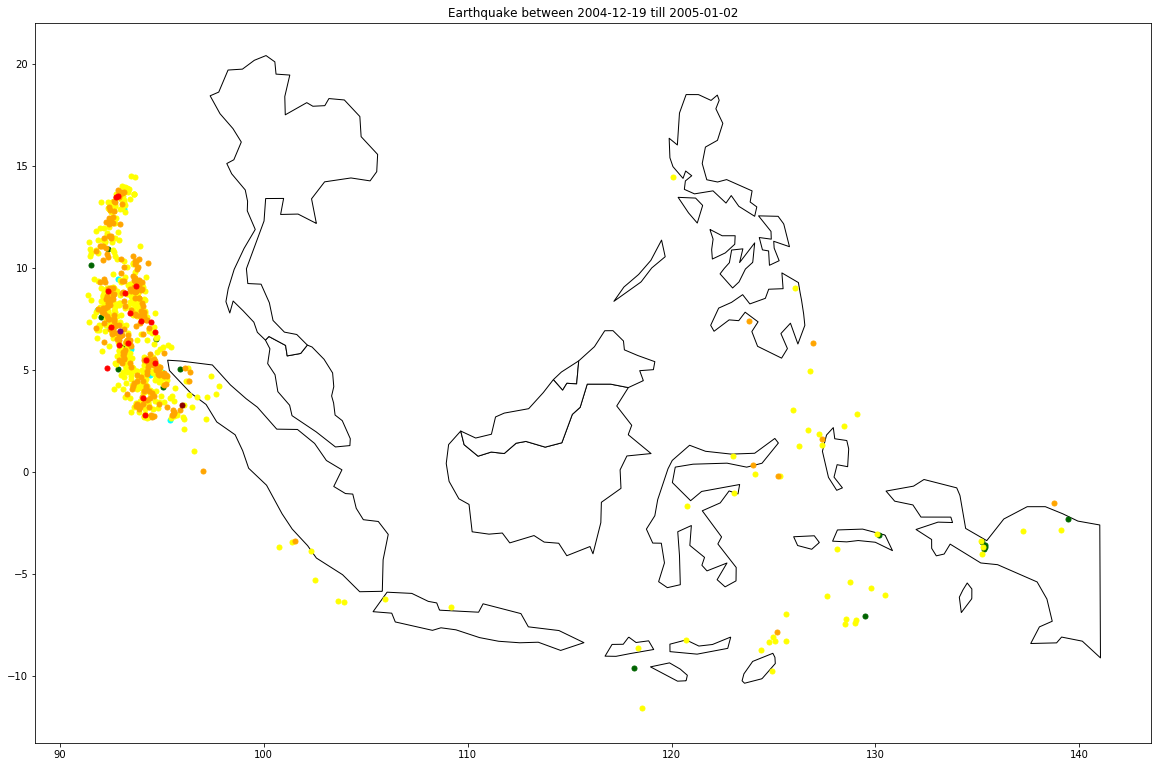

In [15]:
# let's plot on the map
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

crs = {'init': 'epsg:4326'}
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[(world.name=="Indonesia") | (world.name=="Philippines") \
              | (world.name=="Malaysia") | (world.name=="Brunei") \
              | (world.name=="Brunei") | (world.name=="Thailand")]

from matplotlib import cm

base = world.plot(figsize=(20,20),color='white', edgecolor='black')
base.set_title("Earthquake between "+urlStart+" till "+urlEnd)

colorDict = {'Great': 'darkred', # >8
             'Major': 'purple', # >7
             'Strong': 'red', # >6
             'Moderate': 'orange', # >5
             'Light': 'yellow', # >4
             'Minor': 'darkgreen', # >3
             'Not felt': 'cyan' # <3
            }

classType = ['Not felt','Minor','Light','Moderate','Strong','Major','Great']
#classType = ['Moderate','Strong','Major','Great']
for cType in classType:
    if(len(earthquake_df[earthquake_df['Class']==cType])>0):
        subsetDF = earthquake_df[earthquake_df['Class']==cType]
        geometry = [Point(xy) for xy in zip(subsetDF.lon, subsetDF .lat)]
        subsetGDF = GeoDataFrame(subsetDF, crs=crs, geometry=geometry)
    
        subsetGDF.plot(ax=base, marker='.', color=colorDict[cType], markersize=100);

From the map, we can see many occurance of earthquakes around the same area in Northen Acheh.
<br>Let's focus only on that area, filter by coordinates.

# Inspect only area of focus

In [13]:
# Create a copy of dataframe with only covering the Northen Acheh area
# Roughly get the boundaries from the map above
location_latitude = (earthquake_df['lat'] > -5) & (earthquake_df['lat'] < 20)
location_longitude = (earthquake_df['lon'] > 80) & (earthquake_df['lon'] < 100)

acheh_df = earthquake_df[location_latitude & location_longitude].copy()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

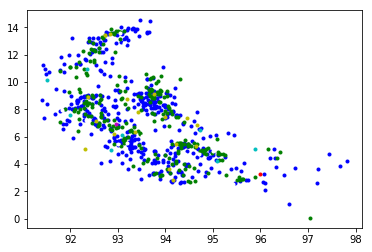

In [16]:
# Just plot into xy-plane to check on the earthquake as we intended
markerDict = {'Great': 'ro', # >8 red
             'Major': 'mo', # >7 magenta
             'Strong': 'yo', # >6 yellow
             'Moderate': 'go', # >5 green
             'Light': 'bo', # >4 blue
             'Minor': 'co', # >3 minor
             'Not felt': 'wo' # <3 white
            }

for cls in acheh_df.Class.unique():
    clscFilter = acheh_df['Class']==cls
    plt.plot(acheh_df[clscFilter].lon,acheh_df[clscFilter].lat, markerDict[cls],markersize=3)

Text(0.5,1,u'Number of earthquake by day')

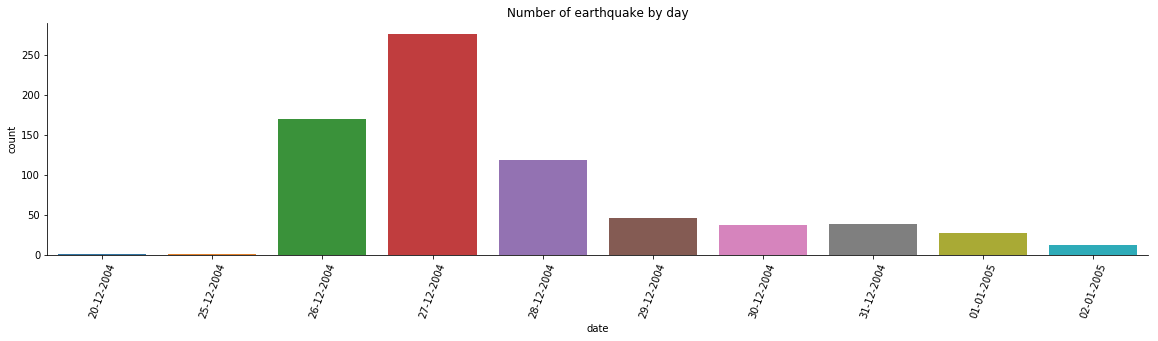

In [17]:
# Check the count by day

sns.factorplot('date',data=acheh_df.sort_values(by='properties.time', ascending=1),kind='count',
               orient="h",aspect=4,legend=True)

plt.xticks(rotation=70)
plt.title("Number of earthquake by day")

In [18]:
acheh_df.groupby(['date'])['geometry.coordinates'].nunique()

date
01-01-2005     27
02-01-2005     12
20-12-2004      1
25-12-2004      1
26-12-2004    170
27-12-2004    276
28-12-2004    119
29-12-2004     46
30-12-2004     38
31-12-2004     39
Name: geometry.coordinates, dtype: int64

27 December recorded the most earthquakes that hit the area.
<br>Also there were significant number of earquakes a day before and after.
<br>Let's plot the earthquake for these 3 days, and illustrate the magnitude level

Text(0.5,1,u'Number of earthquakes between 26-29 December')

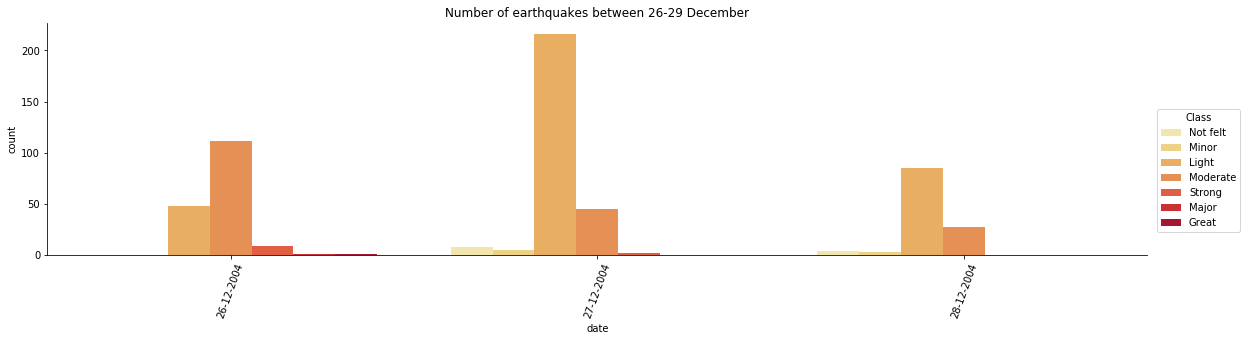

In [19]:
# High volume happened between 26-29 December 2004

dateFilter = (acheh_df['date']>='26-12-2004') & (acheh_df['date']<'29-12-2004')

classPalette = sns.color_palette("YlOrRd", earthquake_df['Class'].nunique())
sns.set_palette(classPalette)

sns.factorplot('date',data=acheh_df[dateFilter].sort_values(by='properties.time', ascending=1),hue='Class',kind='count',
               orient="h",aspect=4,legend=True,hue_order = ['Not felt','Minor','Light','Moderate','Strong','Major','Great'])

plt.xticks(rotation=70)
plt.title("Number of earthquakes between 26-29 December")

Because of high volume of Light earthquakes on 27 December,
<br>we can't clearly see the major earthquakes.
<br>Let's check on the count in tabular format

In [20]:
dateFilter = (acheh_df['date']>='26-12-2004') & (acheh_df['date']<'29-12-2004')
acheh_df[dateFilter].groupby(['date','Class'])['geometry.coordinates'].nunique()

date        Class   
26-12-2004  Great         1
            Light        48
            Major         1
            Moderate    111
            Strong        9
27-12-2004  Light       216
            Minor         5
            Moderate     45
            Not felt      8
            Strong        2
28-12-2004  Light        85
            Minor         3
            Moderate     27
            Not felt      4
Name: geometry.coordinates, dtype: int64

The area was hit by major earthquakes on 26th, with 11 earthquakes with magnitude >=6 (Strong/Major/Great)
<br>Let's visualize these on xy-plot

# What happened on 26th December

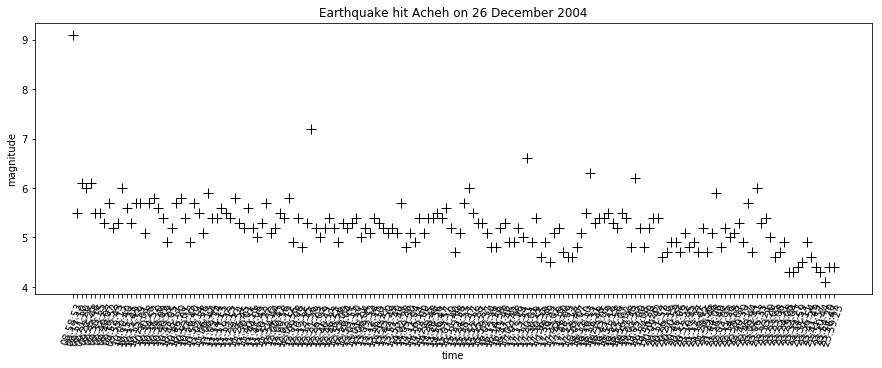

In [21]:
plt.figure(figsize=(15,5))

magnFilter = acheh_df['properties.mag']>=5
dateFilter = acheh_df['date']=='26-12-2004'

plt.plot(acheh_df[dateFilter]['time'],
        acheh_df[dateFilter]['properties.mag'],
         '+k',markersize=10) # black cross

plt.xticks(rotation=70)
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("Earthquake hit Acheh on 26 December 2004")

plt.show()

On 26th December, the area was hit by M9.1 earthquake at 8:58 am
<br>Followed by series of earthquake throughout the day.
<br>From previous line, we found >100 earthquake hit the area on that day
<br>11 with M>=6 and 159 with 4<M<6

In [22]:
# list down the earthquake with magnitude > 6
magnFilter = acheh_df['properties.mag']>=6
dateFilter = acheh_df['date']=='26-12-2004'

acheh_df[dateFilter & magnFilter] \
    .sort_values(by='time', ascending=1) \
    [['properties.place','date','time','Class','properties.mag']]

,properties.place,date,time,Class,properties.mag
741,off the west coast of northern Sumatra,26-12-2004,08:58:53,Great,9.1
739,"Nicobar Islands, India region",26-12-2004,09:21:20,Strong,6.1
738,"Nicobar Islands, India region",26-12-2004,09:22:25,Strong,6.0
737,"northern Sumatra, Indonesia",26-12-2004,09:25:48,Strong,6.1
730,"Nicobar Islands, India region",26-12-2004,10:00:40,Strong,6.0
688,"Nicobar Islands, India region",26-12-2004,12:21:29,Major,7.2
653,"Nicobar Islands, India region",26-12-2004,15:51:17,Strong,6.0
640,"Nicobar Islands, India region",26-12-2004,17:20:01,Strong,6.6
626,"Andaman Islands, India region",26-12-2004,18:19:31,Strong,6.3
616,"Andaman Islands, India region",26-12-2004,19:05:00,Strong,6.2


On 26th December, the area was hit by <b>M9.1</b> earthquake at <b>8:58 am</b>
<br>Followed by series of earthquake throughout the day.
<br>From previous line, we found >100 earthquake hit the area on that day
<br>The area was hit by 5 strong earthquake in 2 hours during that morning
<br>The same area was hit by total of 276 earthquakes on 27th and 119 earthquakes on 28th

# Let's see details on the greatest earthquake on 26th December

In [23]:
# Get the greatest earthquake
dateFilter = acheh_df['date']=='26-12-2004'
maxFilter = acheh_df['properties.mag'] == acheh_df['properties.mag'].max()

acheh_df[dateFilter & maxFilter] \
    .sort_values(by='time', ascending=1) \
    [['properties.place','date','time','Class','properties.mag','properties.detail']]

,properties.place,date,time,Class,properties.mag,properties.detail
741,off the west coast of northern Sumatra,26-12-2004,08:58:53,Great,9.1,https://earthquake.usgs.gov/fdsnws/event/1/que...


In [24]:
# more details can be retrieved as follow
acheh_df.loc[acheh_df['properties.mag'].idxmax()]

geometry.coordinates                                  [95.982, 3.295, 30]
geometry.type                                                       Point
id                                           official20041226005853450_30
properties.alert                                                     None
properties.cdi                                                        9.1
properties.code                                      20041226005853450_30
properties.detail       https://earthquake.usgs.gov/fdsnws/event/1/que...
properties.dmin                                                       NaN
properties.felt                                                       886
properties.gap                                                         22
properties.ids          ,duputel122604a,us2004slav,official20041226005...
properties.mag                                                        9.1
properties.magType                                                     mw
properties.mmi                        

The greatest earthquake on 26th December was with <b>magnitude 9.1</b>, happened <b>08:58:53 am</b>.
<br>The exact location was <b>off the west coast of northern Sumatra</b>

In [25]:
# get the detail from the properties.detail
detailURL = acheh_df.loc[acheh_df['properties.mag'].idxmax()]['properties.detail']
detailURL

u'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=official20041226005853450_30&format=geojson'

From this URL, we can get more details of each earthquake.
<br>I have inspect the json response, and will only focus on some data captured:
1. general-header
2. general-header
3. impact-text
4. poster

In [26]:
# submit the request
resp = requests.get(url=detailURL)
data = resp.json()

# process the JSON response
block_df = json_normalize(data['properties']['products'])

block_df

,associate,dyfi,focal-mechanism,general-header,general-text,impact-text,moment-tensor,origin,phase-data,poster,shakemap,trump-origin,trump-shakemap
0,"[{u'status': u'UPDATE', u'updateTime': 1455831...","[{u'status': u'UPDATE', u'updateTime': 1422426...","[{u'status': u'UPDATE', u'updateTime': 1478745...","[{u'status': u'UPDATE', u'updateTime': 1478558...","[{u'status': u'UPDATE', u'updateTime': 1510165...","[{u'status': u'UPDATE', u'updateTime': 1415323...","[{u'status': u'UPDATE', u'updateTime': 1423758...","[{u'status': u'UPDATE', u'updateTime': 1361955...","[{u'status': u'UPDATE', u'updateTime': 1415323...","[{u'status': u'UPDATE', u'updateTime': 1457989...","[{u'status': u'UPDATE', u'updateTime': 1491979...","[{u'status': u'UPDATE', u'updateTime': 1439485...","[{u'status': u'UPDATE', u'updateTime': 1492121..."


In [27]:
headerBlock = block_df['general-header']
type(headerBlock)

pandas.core.series.Series

In [28]:
from IPython.core.display import display, HTML

for h1 in headerBlock:
    #print "h1 is",type(h1)    # list
    for h2 in h1:
        #print "h2 is",type(h2)  # dict
        h2Content = h2['contents']
        #print "h2Content is",type(h2Content)  # dict
        #print h2Content['']['bytes']
        display(HTML(h2Content['']['bytes']))

In [29]:
textBlock = block_df['general-text']
for h1 in textBlock:
    #print "h1 is",type(h1)    # list
    for h2 in h1:
        #print "h2 is",type(h2)  # dict
        h2Content = h2['contents']
        #print "h2Content is",type(h2Content)  # dict
        #print h2Content['']['bytes']
        display(HTML(h2Content['']['bytes']))

In [30]:
impactBlock = block_df['impact-text']
for h1 in impactBlock:
    #print "h1 is",type(h1)    # list
    for h2 in h1:
        #print "h2 is",type(h2)  # dict
        h2Content = h2['contents']
        #print "h2Content is",type(h2Content)  # dict
        #print h2Content['']['bytes']
        display(HTML(h2Content['']['bytes']))

In [31]:
from IPython.display import Image
from IPython.core.display import HTML

imgUrl = ""

posterBlock = block_df['poster']
for h1 in posterBlock:
    #print "h1 is",type(h1)    # list
    for h2 in h1:
        #print "h2 is",type(h2)  # dict
        imgUrl = h2['contents']['poster.jpg']['url']
        print imgUrl

Image(url= imgUrl)

https://earthquake.usgs.gov/archive/product/poster/20041226/us/1457989040172/poster.jpg
